# Pressure Scales Notebook

This notebook provides an analysis of the pressure scale using more than one pressure marker.

We include the scales for Pt, KCl, Ruby and Sm:YAg.

To include additional/different pressure markers, the user would copy the code below (e.g., the code for Pt) and input their own values for the parameters.

In [58]:
import numpy as np
import uncertainties as uct
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pytheos as eos
import matplotlib.colors as mcolors
import plotly.graph_objects as go

from lmfit import Model, minimize
from scipy.optimize import curve_fit
from scipy import constants
from scipy.integrate import quad
from math import exp
from uncertainties import ufloat
from uncertainties import unumpy as unp
from pytheos.scales.objs import MGEOS
from plotly.subplots import make_subplots
from collections import OrderedDict

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# High Temperature Birch-Murnaghan Equation of State (HTBM3)

In [59]:
# DO NOT CHANGE ANYTHING
# CREATING FUNCTION TO CALCULATE PRESSURE USING BM3 + POLYNOMIAL MODEL
class BM3POLYequation:
        def __init__(self, v_std, temp, v0, k0_3c, k0p_3c, a0, a1, dK_dT):
            self.v = unp.nominal_values(v_std)
            self.verr = unp.std_devs(v_std)
            self.temp = unp.nominal_values(temp)
            self.temperr = unp.std_devs(temp)
            self.v0 = v0
            self.k0_3c = k0_3c
            self.k0p_3c = k0p_3c
            self.a0 = a0
            self.a1 = a1
            self.dK_dT = dK_dT
        
        def calculate(self):
            ptotal_values = []
            ptotal_err = []  # initialization

            for temp_val, v_val, v_err, temp_err in zip(self.temp, self.v, self.verr, self.temperr):
                v_T = self.v0 * (1 + self.a0 * (temp_val - 300) + 1/2 * self.a1 * (temp_val - 300) ** 2)
                K_T = self.k0_3c + self.dK_dT * (temp_val - 300)
                pressure_term = ((v_T / v_val) ** (7 / 3) - (v_T / v_val) ** (5 / 3))
                correction_term = (1 + 3 / 4 * (self.k0p_3c - 4) * ((v_T / v_val) ** (2 / 3) - 1))
                p_value = 3 * K_T / 2 * pressure_term * correction_term
                ptotal_values.append(p_value)
                
                # Propagation of uncertainty
                dp_dv = -7/3 * p_value / v_val + 5/3 * p_value / v_val
                dp_dT = p_value / temp_val
                perror = np.sqrt((dp_dv * v_err) ** 2 + (dp_dT * temp_err) ** 2)
                ptotal_err.append(perror)

            return np.array(ptotal_values), np.array(ptotal_err)

# Mie-Debye-Gruneisen Equation of State (MGD)

The function for this model is already created in Pytheos as MGEOS. We will be using it for different pressure scales below.

# EOS using Au

In [60]:
# Read data from .csv file just as with Pytheos
# In this example, v_std is the volume of gold. 
# In this case, the user would go down to the gold section and use Pytheos's gold scale.
# Note the names of the columns when reproducing this dataset with your own data
dataAu = pd.read_csv('./data/exampleAu.csv')
v_stdAu = unp.uarray( dataAu['V(Au)'], dataAu['sV(Au)']) 
tempAu = unp.uarray( dataAu['T(sample)'], dataAu['sT(sample)']) 
vAu = unp.uarray( dataAu['V(sample)'], dataAu['sV(sample)']) 

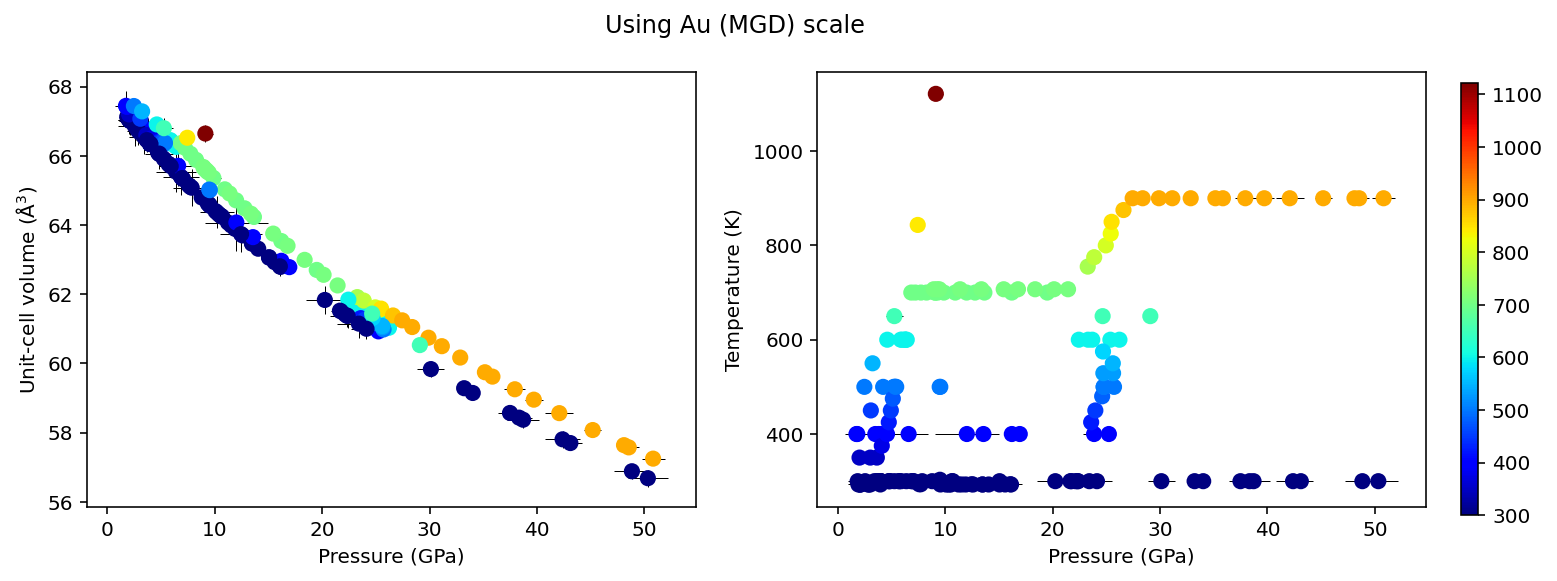

In [61]:
# calculate Au pressure using Pytheos (MGD)
# info in gold.py line 135 and objs.py line 31
# Pytheos has many scales for gold, here we use the Fei2007 scale
key = 'Fei2007'
au_eos = {key: eos.gold.Fei2007bm3()}

pgold = au_eos[key].cal_p(v_stdAu, tempAu)
pgold_values = unp.nominal_values(pgold)
pgold_uncertainties = unp.std_devs(pgold)

for key, value in au_eos.items(): # iterations for different pressure scales
    p = au_eos[key].cal_p(v_stdAu, tempAu)
    eos.plot.thermal_data({'p': p, 'v': vAu, 'temp': tempAu}, title= 'Using Au (MGD) scale')

# EOS using Pt

In [62]:
# Read data from .csv file 
dataPt = pd.read_csv('./data/examplePt.csv')
v_stdPt = unp.uarray( dataPt['V(Pt)'], dataPt['sV(Pt)']) 
tempPt = unp.uarray( dataPt['T(sample)'], dataPt['sT(sample)']) 
vPt = unp.uarray( dataPt['V(sample)'], dataPt['sV(sample)']) 

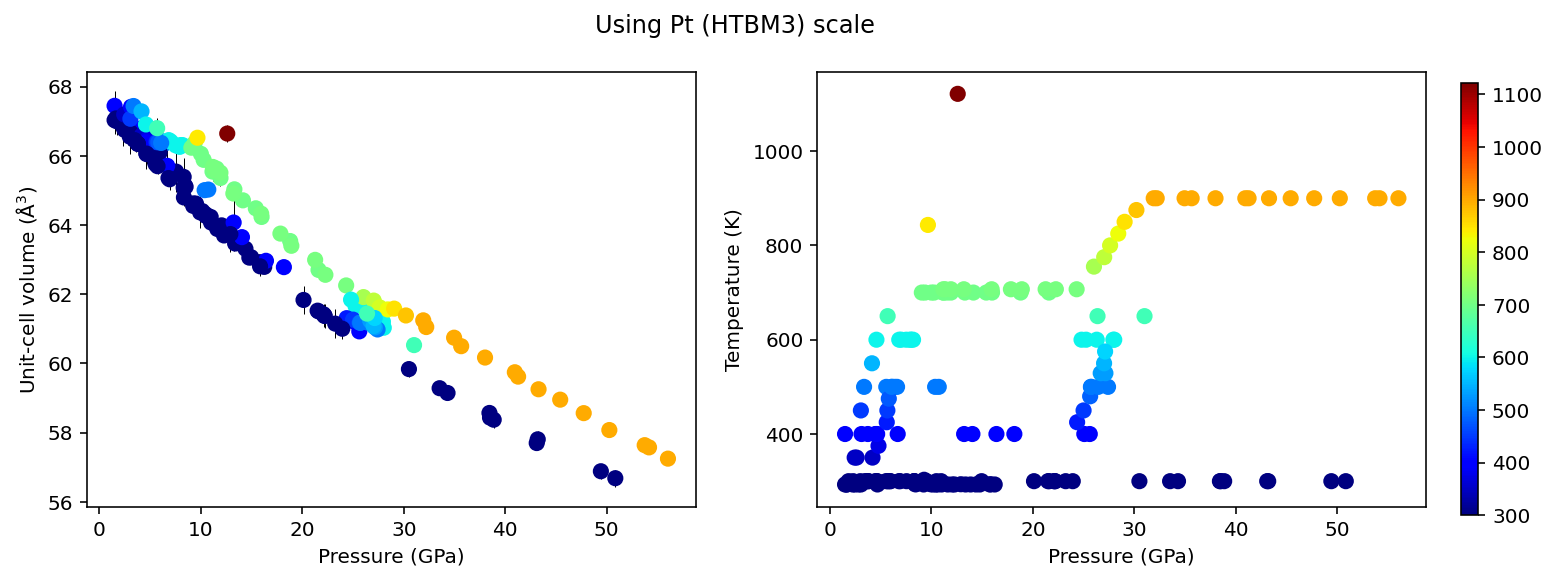

In [63]:
# Calculate Pt pressure (BHTBM3)
class PTbm3poly(BM3POLYequation):
    def __init__(self, v_stdPt, temPtp):
        v0 = 60.32
        k0_3c = 294
        k0p_3c = 3.3
        a0 = 4.26*10**-5
        a1 = -1.49*10**-9
        dK_dT = -0.02
        super().__init__(v_stdPt, tempPt, v0, k0_3c, k0p_3c, a0, a1, dK_dT)

pptbm3poly = PTbm3poly(v_stdPt, tempPt)
pptbm3poly_values, pptbm3poly_errors = pptbm3poly.calculate()

eos.plot.thermal_data({'p': pptbm3poly_values, 'p_err': pptbm3poly_errors, 'v': vPt, 'temp': tempPt}, title='Using Pt (HTBM3) scale')

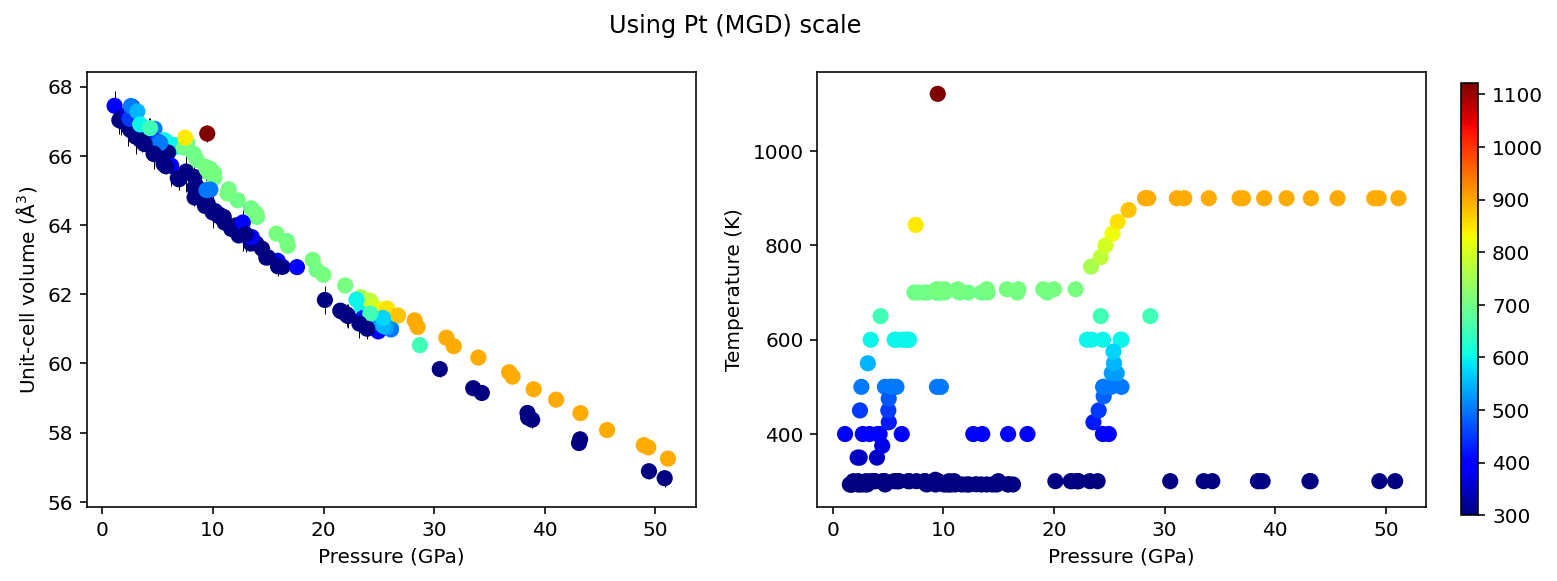

In [64]:
#calculate Pt pressure (MGD)
class PTbm3mdg(MGEOS):
    def __init__(self):
        params_st = OrderedDict([('v0', uct.ufloat(60.32, 0.01)),
                                 ('k0', uct.ufloat(294., 4)),
                                 ('k0p', uct.ufloat(3.3, 0.3))])
        params_th = OrderedDict([('v0', uct.ufloat(57.4, 0.05)),
                                 ('gamma0', uct.ufloat(2.75, 0.03)),
                                 ('q', uct.ufloat(2.75, 0.0)),
                                 ('theta0', uct.ufloat(230., 0.0))])
        reference = 'Pt, this study'
        MGEOS.__init__(self, n, z, params_st=params_st, params_th=params_th,
                       eqn_st='bm3', eqn_th='constq', reference=reference)

    def __call__(self, v_stdPt, tempPt):
        pptbm3mdg = self.cal_p(v_stdPt, tempPt)
        pptbm3mdg_values = unp.nominal_values(pptbm3mdg)
        pptbm3mdg_uncertainties = unp.std_devs(pptbm3mdg)
        
        return pptbm3mdg_values, pptbm3mdg_uncertainties

n=1
z=4

pptbm3mdg_eos = PTbm3mdg()
pptbm3mdg_values, pptbm3mdg_uncertainties = pptbm3mdg_eos(v_stdPt, tempPt)

eos.plot.thermal_data({'p': pptbm3mdg_values, 'p_err': pptbm3mdg_uncertainties, 'v': vPt, 'temp': tempPt}, title='Using Pt (MGD) scale')

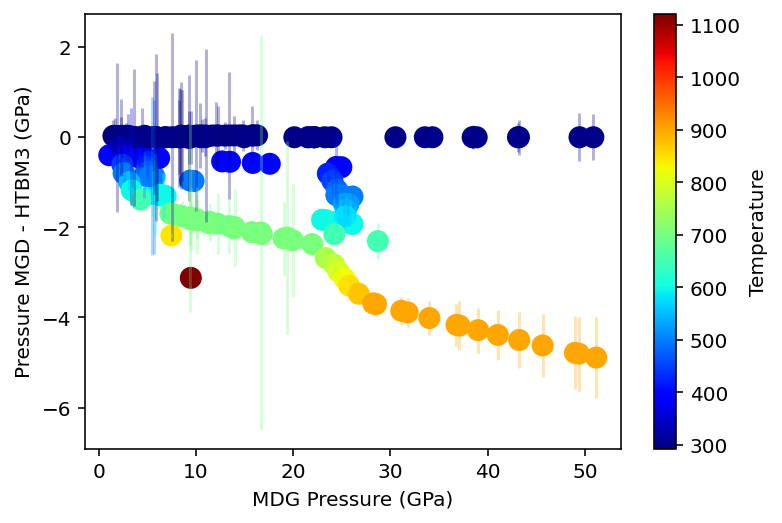

In [65]:
# Compute the quantities for plotting
delPt = pptbm3mdg_values - pptbm3poly_values
delPterr = pptbm3mdg_uncertainties - pptbm3poly_errors
temp_nominal = unp.nominal_values(tempPt)

scatter = plt.scatter(pptbm3mdg_values, delPt, c=temp_nominal, cmap=cm.jet, s=100)
colors = scatter.to_rgba(temp_nominal)
plt.errorbar(pptbm3mdg_values, delPt, yerr=delPterr, fmt='none', ecolor=colors, alpha=0.3)

plt.colorbar(label='Temperature') # Show color scale
plt.xlabel('MDG Pressure (GPa)')
plt.ylabel('Pressure MGD - HTBM3 (GPa)')
plt.show()

# EOS using KCl

In [66]:
# Read data from .csv file 
dataKCl = pd.read_csv('./data/exampleKCl.csv')
v_stdKCl = unp.uarray( dataKCl['V(KCl)'], dataKCl['sV(KCl)']) 
tempKCl = unp.uarray( dataKCl['T(sample)'], dataKCl['sT(sample)']) 
vKCl = unp.uarray( dataKCl['V(sample)'], dataKCl['sV(sample)']) 

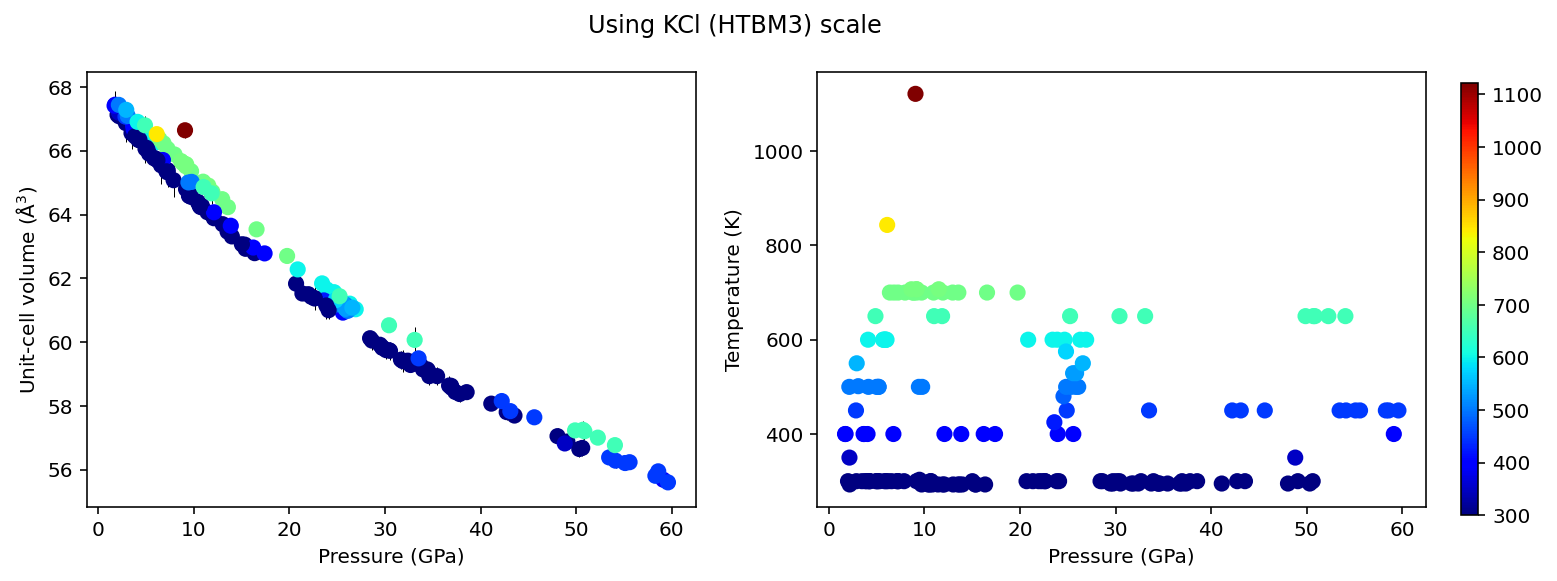

In [67]:
#calculate KCl pressure (HTBM3)
class KCLbm3poly(BM3POLYequation):
    def __init__(self, v_stdKCl, tempKCl):
        v0 = 54.09
        k0_3c = 22.99
        k0p_3c = 4.34
        a0 = 1.78*10**-4
        a1 = 1.17*10**-7
        dK_dT = -0.01
        super().__init__(v_stdKCl, tempKCl, v0, k0_3c, k0p_3c, a0, a1, dK_dT)

pkclbm3poly = KCLbm3poly(v_stdKCl, tempKCl)
pkclbm3poly_values, pkclbm3poly_errors = pkclbm3poly.calculate()

eos.plot.thermal_data({'p': pkclbm3poly_values, 'p_err': pkclbm3poly_errors, 'v': vKCl, 'temp': tempKCl}, title='Using KCl (HTBM3) scale')

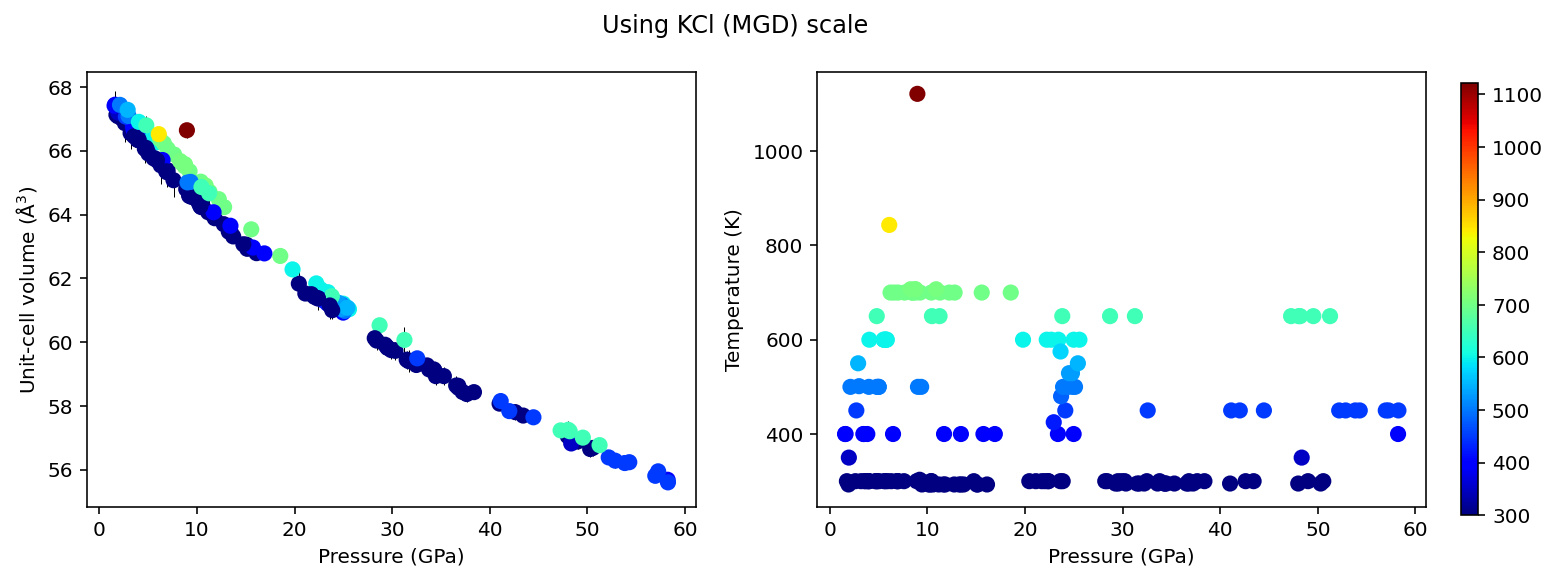

In [68]:
#calculate KCl pressure (MGD)
class KCLbm3mdg(MGEOS):
    def __init__(self):
        params_st = OrderedDict([('v0', uct.ufloat(53.5, 0.1)),
                                 ('k0', uct.ufloat(23.9, 0.4)),
                                 ('k0p', uct.ufloat(4.35, 0.04))])
        params_th = OrderedDict([('v0', uct.ufloat(50, 1)),
                                 ('gamma0', uct.ufloat(1.78, 0.00)),
                                 ('q', uct.ufloat(0.8, 0.1)),
                                 ('theta0', uct.ufloat(235., 0.0))])
        reference = 'KCl, this study'
        MGEOS.__init__(self, n, z, params_st=params_st, params_th=params_th,
                       eqn_st='bm3', eqn_th='constq', reference=reference)

    def __call__(self, v_stdKCl, tempKCl):
        pkclbm3mdg = self.cal_p(v_stdKCl, tempKCl)
        pkclbm3mdg_values = unp.nominal_values(pkclbm3mdg)
        pkclbm3mdg_uncertainties = unp.std_devs(pkclbm3mdg)
        
        return pkclbm3mdg_values, pkclbm3mdg_uncertainties

n=1
z=4

pkclbm3mdg_eos = KCLbm3mdg()
pkclbm3mdg_values, pkclbm3mdg_uncertainties = pkclbm3mdg_eos(v_stdKCl, tempKCl)

eos.plot.thermal_data({'p': pkclbm3mdg_values, 'p_err': pkclbm3mdg_uncertainties, 'v': vKCl, 'temp': tempKCl}, title='Using KCl (MGD) scale')

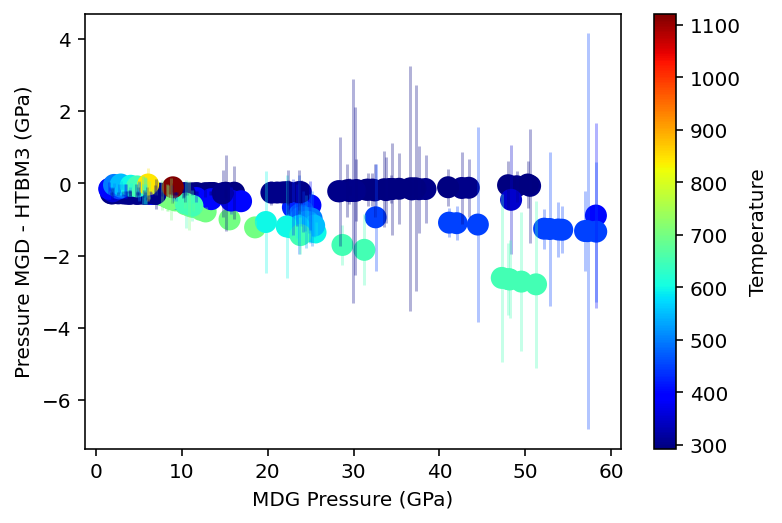

In [69]:
# Compute the quantities for plotting
delKCl = pkclbm3mdg_values - pkclbm3poly_values
delKClerr = pkclbm3mdg_uncertainties - pkclbm3poly_errors
temp_nominal = unp.nominal_values(tempKCl)

scatter = plt.scatter(pkclbm3mdg_values, delKCl, c=temp_nominal, cmap=cm.jet, s=100)
colors = scatter.to_rgba(temp_nominal)
plt.errorbar(pkclbm3mdg_values, delKCl, yerr=delKClerr, fmt='none', ecolor=colors, alpha=0.3)

plt.colorbar(label='Temperature') # Show color scale
plt.xlabel('MDG Pressure (GPa)')
plt.ylabel('Pressure MGD - HTBM3 (GPa)')
plt.show()

# EOS using Ruby

In [70]:
# Read data from .csv file 
dataRuby = pd.read_csv('./data/exampleRuby.csv')
v_stdRuby = unp.uarray( dataRuby['V(Ruby)'], dataRuby['sV(Ruby)']) 
tempRuby = unp.uarray( dataRuby['T(sample)'], dataRuby['sT(sample)']) 
vRuby = unp.uarray( dataRuby['V(sample)'], dataRuby['sV(sample)']) 

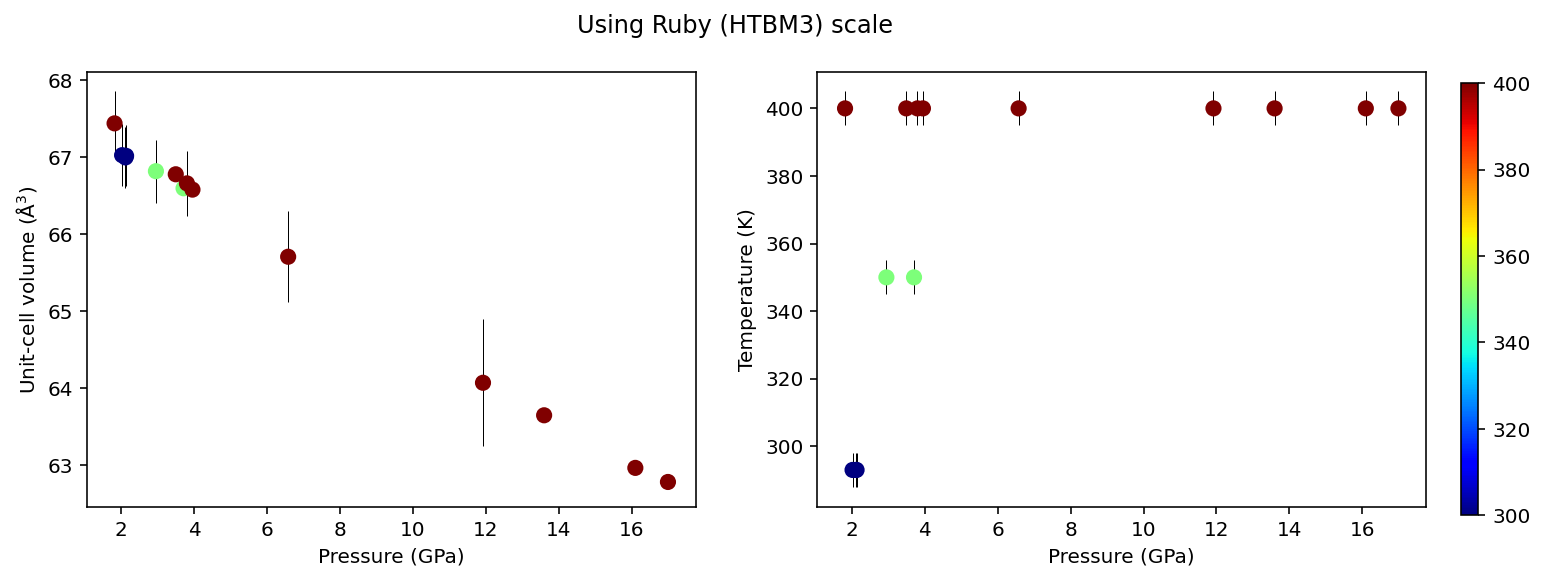

In [71]:
#calculate Ruby pressure (HTBM3)
class RUBYbm3poly(BM3POLYequation):
    def __init__(self, v_stdRuby, tempRuby):
        v0 = 255.61
        k0_3c = 246
        k0p_3c = 4
        a0 = 2.81*10**-5
        a1 = 7.24*10**-9
        dK_dT = -0.04
        super().__init__(v_stdRuby, tempRuby, v0, k0_3c, k0p_3c, a0, a1, dK_dT)

prubybm3poly = RUBYbm3poly(v_stdRuby, tempRuby)
prubybm3poly_values, prubybm3poly_errors = prubybm3poly.calculate()

eos.plot.thermal_data({'p': prubybm3poly_values, 'p_err': prubybm3poly_errors, 'v': vRuby, 'temp': tempRuby}, title='Using Ruby (HTBM3) scale')

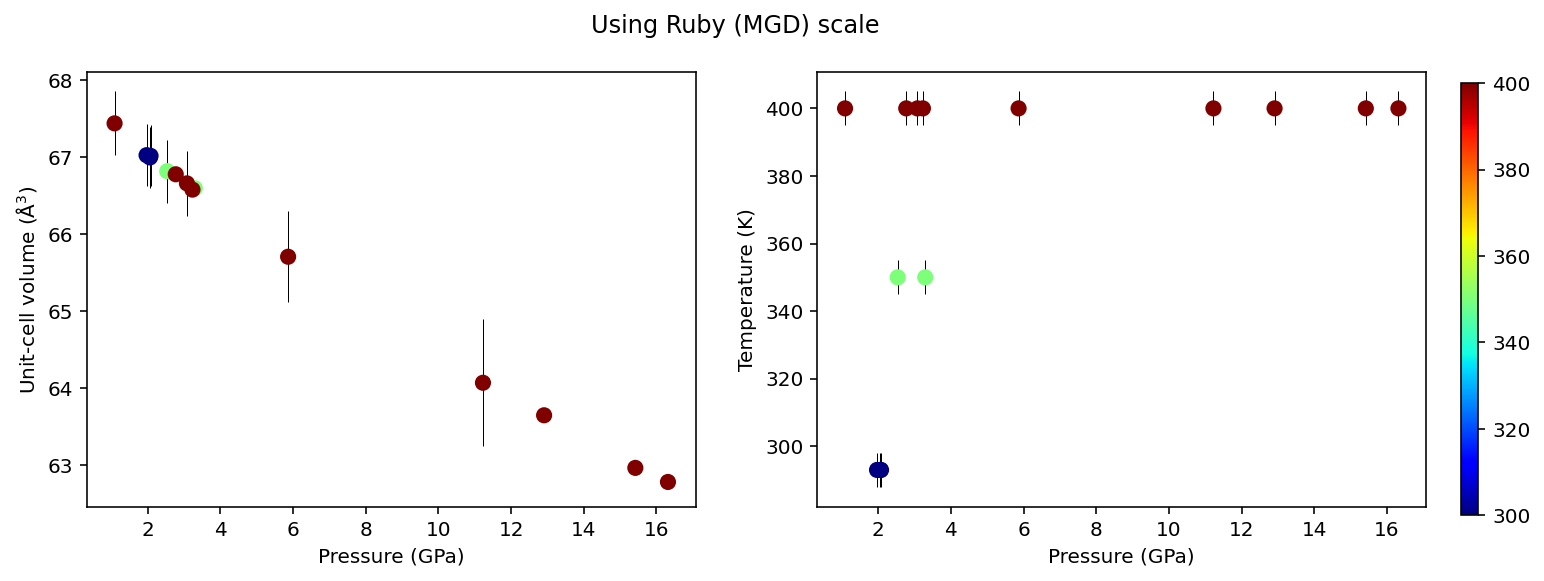

In [72]:
#calculate Ruby pressure (MGD)
class RUBYbm3mdg(MGEOS):
    def __init__(self):
        params_st = OrderedDict([('v0', uct.ufloat(255.51, 0.0)),
                                 ('k0', uct.ufloat(246, 0.0)),
                                 ('k0p', uct.ufloat(4, 0.0))])
        params_th = OrderedDict([('v0', uct.ufloat(255.51, 0.00)),
                                 ('gamma0', uct.ufloat(1.32, 0.0)),
                                 ('q', uct.ufloat(-0.03, 0.6)),
                                 ('theta0', uct.ufloat(1100., 0.0))])
        reference = 'Ruby, this study'
        MGEOS.__init__(self, n, z, params_st=params_st, params_th=params_th,
                       eqn_st='bm3', eqn_th='constq', reference=reference)

    def __call__(self, v_stdRuby, tempRuby):
        prubybm3mdg = self.cal_p(v_stdRuby, tempRuby)
        prubybm3mdg_values = unp.nominal_values(prubybm3mdg)
        prubybm3mdg_uncertainties = unp.std_devs(prubybm3mdg)
        
        return prubybm3mdg_values, prubybm3mdg_uncertainties

n=1
z=4

prubybm3mdg_eos = RUBYbm3mdg()
prubybm3mdg_values, prubybm3mdg_uncertainties = prubybm3mdg_eos(v_stdRuby, tempRuby)

eos.plot.thermal_data({'p': prubybm3mdg_values, 'p_err': prubybm3mdg_uncertainties, 'v': vRuby, 'temp': tempRuby}, title='Using Ruby (MGD) scale')

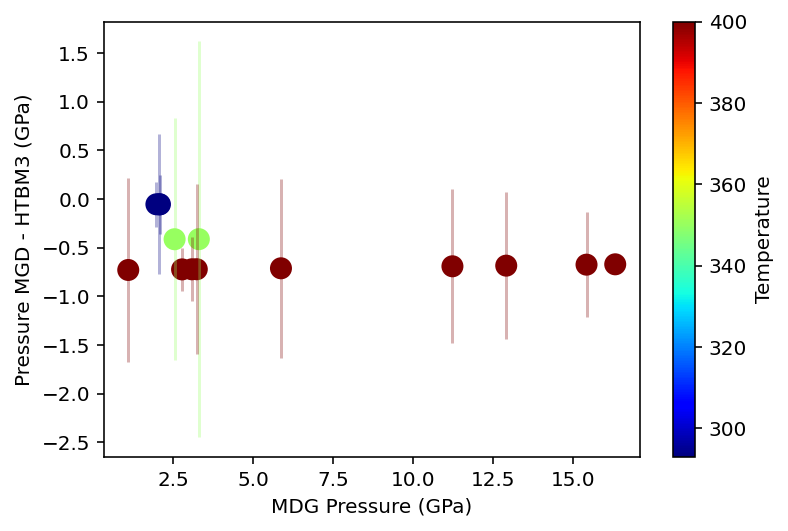

In [73]:
# Compute the quantities for plotting
delRuby = prubybm3mdg_values - prubybm3poly_values
delRubyerr = prubybm3mdg_uncertainties - prubybm3poly_errors
temp_nominal = unp.nominal_values(tempRuby)

scatter = plt.scatter(prubybm3mdg_values, delRuby, c=temp_nominal, cmap=cm.jet, s=100)
colors = scatter.to_rgba(temp_nominal)
plt.errorbar(prubybm3mdg_values, delRuby, yerr=delRubyerr, fmt='none', ecolor=colors, alpha=0.3)

plt.colorbar(label='Temperature') # Show color scale
plt.xlabel('MDG Pressure (GPa)')
plt.ylabel('Pressure MGD - HTBM3 (GPa)')
plt.show()

# EOS using Sm:YAg 

In [74]:
# Read data from .csv file 
dataYAg = pd.read_csv('./data/exampleYag.csv')
v_stdYAg = unp.uarray( dataYAg['V(Yag)'], dataYAg['sV(Yag)']) 
tempYAg = unp.uarray( dataYAg['T(sample)'], dataYAg['sT(sample)']) 
vYAg = unp.uarray( dataYAg['V(sample)'], dataYAg['sV(sample)']) 

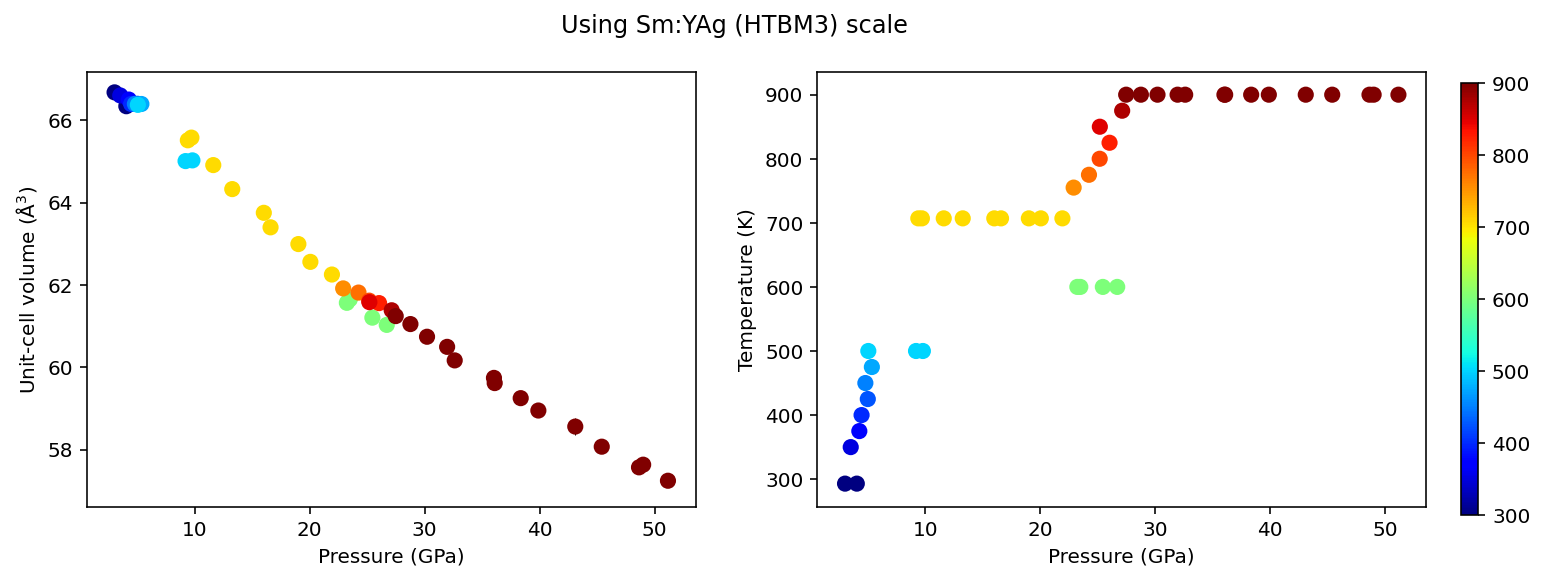

In [75]:
#calculate Sm:YAg pressure (HTBM3)
class YAGbm3poly(BM3POLYequation):
    def __init__(self, v_stdYAg, tempYAg):
        v0 = 47.07
        k0_3c = 185.96
        k0p_3c = 4
        a0 = 3.81*10**-5
        a1 = 6.75*10**-9
        dK_dT = -0.02
        super().__init__(v_stdYAg, tempYAg, v0, k0_3c, k0p_3c, a0, a1, dK_dT)

pyagbm3poly = YAGbm3poly(v_stdYAg, tempYAg)
pyagbm3poly_values, pyagbm3poly_errors = pyagbm3poly.calculate()

eos.plot.thermal_data({'p': pyagbm3poly_values, 'p_err': pyagbm3poly_errors, 'v': vYAg, 'temp': tempYAg}, title='Using Sm:YAg (HTBM3) scale')

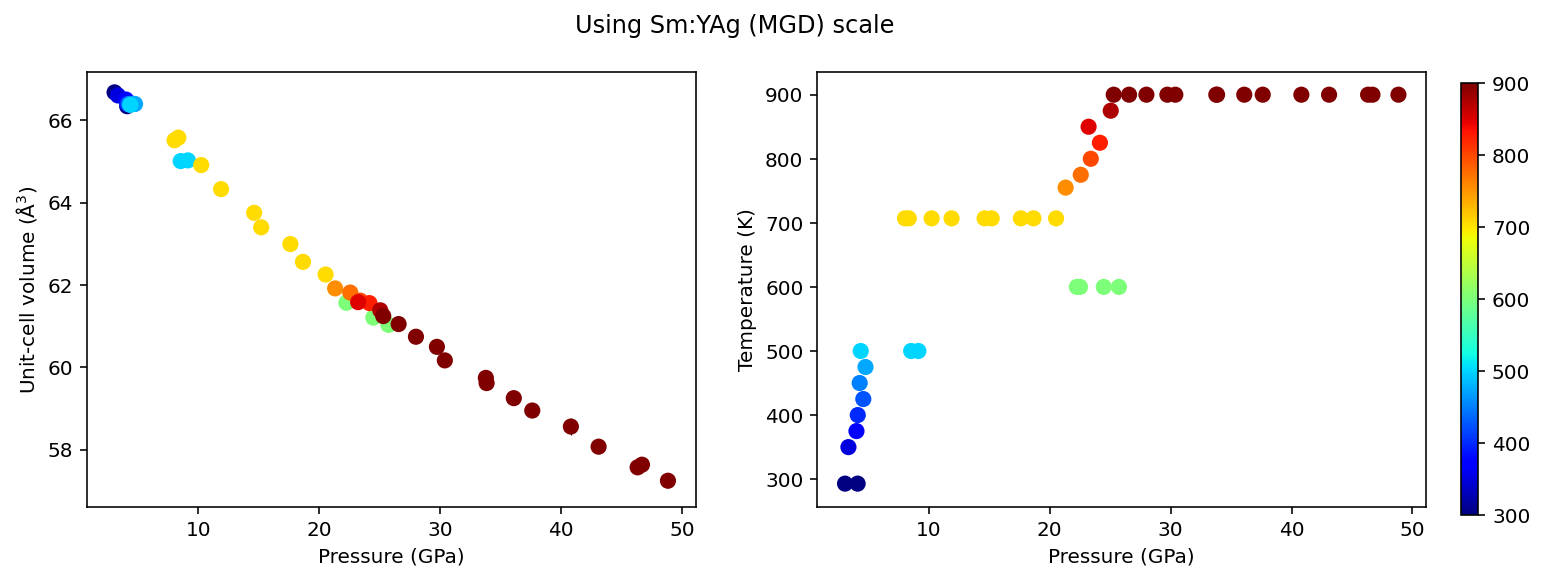

In [76]:
#calculate Sm:YAg pressure (MGD)
class YAGbm3mdg(MGEOS):
    def __init__(self):
        params_st = OrderedDict([('v0', uct.ufloat(47.06, 0.03)),
                                 ('k0', uct.ufloat(189, 5)),
                                 ('k0p', uct.ufloat(4, 0.5))])
        params_th = OrderedDict([('v0', uct.ufloat(48, 3)),
                                 ('gamma0', uct.ufloat(1.32, 0.0)),
                                 ('q', uct.ufloat(1.16, 0.0)),
                                 ('theta0', uct.ufloat(730., 0.0))])
        reference = 'Ruby, this study'
        MGEOS.__init__(self, n, z, params_st=params_st, params_th=params_th,
                       eqn_st='bm3', eqn_th='constq', reference=reference)

    def __call__(self, v_stdYAg, tempYAg):
        pyagbm3mdg = self.cal_p(v_stdYAg, tempYAg)
        pyagbm3mdg_values = unp.nominal_values(pyagbm3mdg)
        pyagbm3mdg_uncertainties = unp.std_devs(pyagbm3mdg)
        
        return pyagbm3mdg_values, pyagbm3mdg_uncertainties

n=1
z=4

pyagbm3mdg_eos = YAGbm3mdg()
pyagbm3mdg_values, pyagbm3mdg_uncertainties = pyagbm3mdg_eos(v_stdYAg, tempYAg)

eos.plot.thermal_data({'p': pyagbm3mdg_values, 'p_err': pyagbm3mdg_uncertainties, 'v': vYAg, 'temp': tempYAg}, title='Using Sm:YAg (MGD) scale')

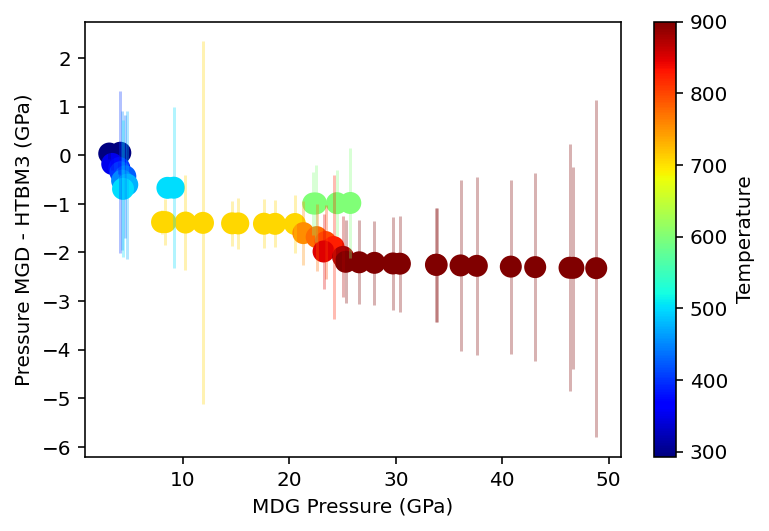

In [77]:
# Compute the quantities for plotting
delYag = pyagbm3mdg_values - pyagbm3poly_values
delYagerr = pyagbm3mdg_uncertainties - pyagbm3poly_errors
temp_nominal = unp.nominal_values(tempYAg)

scatter = plt.scatter(pyagbm3mdg_values, delYag, c=temp_nominal, cmap=cm.jet, s=100)
colors = scatter.to_rgba(temp_nominal)
plt.errorbar(pyagbm3mdg_values, delYag, yerr=delYagerr, fmt='none', ecolor=colors, alpha=0.3)

plt.colorbar(label='Temperature') # Show color scale
plt.xlabel('MDG Pressure (GPa)')
plt.ylabel('Pressure MGD - HTBM3 (GPa)')
plt.show()

# Internally Consistent Pressure Scale

Organize the data, you may change this dictionary according to your materials.

In [78]:
materials = {
    "Au (MDG)": {
            "Xvalues": pgold_values,
            "errors": pgold_uncertainties,
            "Yvalues": v_stdAu,
            "temp": tempAu,
        },
        "Pt (HTBM3)": {
            "Xvalues": pptbm3poly_values,
            "errors": pptbm3poly_errors,
            "Yvalues": vPt,
            "temp": tempPt,
        },
        "Pt (MDG)": {
            "Xvalues": pptbm3mdg_values,
            "errors": pptbm3mdg_uncertainties,
            "Yvalues": vPt,
            "temp": tempPt,
        },
        "KCl (HTBM3)": {
            "Xvalues": pkclbm3poly_values,
            "errors": pkclbm3poly_errors,
            "Yvalues": vKCl,
            "temp": tempKCl,
        },
        "KCl (MDG)": {
            "Xvalues": pkclbm3mdg_values,
            "errors": pkclbm3mdg_uncertainties,
            "Yvalues": vKCl,
            "temp": tempKCl,
        },
        "Ruby (HTBM3)": {
            "Xvalues": prubybm3poly_values,
            "errors": prubybm3poly_errors,
            "Yvalues": vRuby,
            "temp": tempRuby,
        },
        "Ruby (MDG)": {
            "Xvalues": prubybm3mdg_values,
            "errors": prubybm3mdg_uncertainties,
            "Yvalues": vRuby,
            "temp": tempRuby,
        },
        "Sm:YAg (HTBM3)": {
            "Xvalues": pyagbm3poly_values,
            "errors": pyagbm3poly_errors,
            "Yvalues": vYAg,
            "temp": tempYAg,
        },
        "Sm:YAg (MDG)": {
            "Xvalues": pyagbm3mdg_values,
            "errors": pyagbm3mdg_uncertainties,
            "Yvalues": vYAg,
            "temp": tempYAg,
        }
}

Create interactive Figure

In [93]:
# Define different markers for each material for differentiation
markers = iter(['o', 's', 'D', '^', 'v', '<', '>', 'p', '*'])

# Create a new figure
fig = go.Figure()

min_temp = 300.0
max_temp = 1150.0
marker_symbols = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'triangle-left', 'triangle-right', 'star', 'cross']

for idx, (material, data) in enumerate(materials.items()):
    x = data["Xvalues"]
    y = [val.nominal_value for val in data["Yvalues"]]
    temp = [val.nominal_value for val in data["temp"]]
    yerr = [val.std_dev for val in data["Yvalues"]]
    xerr = data["errors"]
    
    # Add scatter plot
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=material,
        marker=dict(
            color=temp,
            colorscale='hsv',  # Using the reversed color scale
            colorbar=dict(title='T(K)'),
            cmin=min_temp,
            cmax=max_temp,
            symbol=marker_symbols[idx],
            size=10,
        ),
        error_y=dict(
            type='data',  # Value of error bar given in data coordinates
            array=yerr,
            visible=True,
            color='rgba(0,0,0,0.2)'  # Making error bars slightly transparent
        ),
        error_x=dict(
            type='data',
            array=xerr,
            visible=True,
            color='rgba(0,0,0,0.2)'  # Making error bars slightly transparent
        ),
    ))

fig.update_layout(
    title=dict(text='Internally Consistent Pressure Scale', x=0.2, y=0.85),
    xaxis_title='Pressure (GPa)',
    yaxis_title='Sample Volume (Å³)',
    showlegend=True,
    legend_title="Material",
    legend=dict(x=1.25, y=0.5),
    plot_bgcolor='white',
    xaxis=dict(gridcolor='grey', linecolor='black', zerolinecolor='black', zerolinewidth=0.2, range=[0,60], dtick=10),
    yaxis=dict(gridcolor='grey', linecolor='black', zerolinecolor='black')

)

# Show the plot
fig.show()

You may use the interactive tool to visualize the differences between each material at different P,T conditions for the same sample. 